## Topic Model using NMF

Adapted from [Topic Model Tutorial by Derek Greene](https://github.com/derekgreene/topic-model-tutorial),  [Improving Interpretation of Topic Models](https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d), and [How Stuff Works: A Comprehensive Topic Modelling Guide with NMF, LSA, PLSA, LDA & lda2vec (Part-1)](https://medium.com/@souravboss.bose/comprehensive-topic-modelling-with-nmf-lsa-plsa-lda-lda2vec-part-1-20002a8e03ae).

### Dependencies
*  Gensim (v3.3.0)  
*  Lda2vec (v0.12.0)    
*  Nltk (v3.2.3)  
*  Scikit-learn (v0.19.1)  
*  Spacy (v2.0.11)  

### Loading the Documents

We us as our training corpus the letters extracted from year 1974. These letters have already gone through initial preprocessing to correct spelling arising from OCR, remove special characters and flatten each letter into one line, and lowercase the texts. Each letter is in a single file. We will load these letters into a list, and also create a short snippet of text for each document.

In [1]:
import os
import re
import sys
import glob
import math
import nltk
from collections import Counter
from pathlib import Path
from pprint import pprint

from gensim.models import Phrases
from gensim.models.phrases import Phraser

from nltk.stem.snowball import SnowballStemmer
english_stemmer = SnowballStemmer("english") 
    
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

current_directory = os.getcwd()
prj_root = os.path.dirname(current_directory)
data_dir = f'{prj_root}/data'
annif_unesco_dir = f'{data_dir}/annif/letters-unesco'
vocabs_dir = f'{prj_root}/data/vocabs'
txt_proc_dir = f'{prj_root}/data/TXT_PROC'

proc_year = "1978"
path_list = []
for f in sorted(Path(txt_proc_dir).glob(f'{proc_year}/*.txt')):
    txt_path = str(f) # cast PosixPath to str
    txt_name = os.path.basename(txt_path)
    path_list.append(txt_name)

raw_documents = []
snippets = []
for idx, path in enumerate(path_list):
    txt_name = os.path.basename(path)
    txt_sans_ext = os.path.splitext(txt_name)[0]
    txt_pre_path = f"{txt_proc_dir}/{proc_year}/{path}"
    
    # only handle valid files i.e. files with useful size of text
    if os.stat(txt_pre_path).st_size > 50: # more 50 bytes at least
        with open(txt_pre_path, 'r', encoding='utf-8') as infile:
            whole_text = infile.read()
            
            # lemmatize
            #word_list = nltk.word_tokenize(whole_text) # Tokenize: Split the sentence into words
            #whole_text = " ".join([wnl.lemmatize(w) for w in word_list]) # Lemmatize list of words and join
            
            # stemmer
            #word_list = nltk.word_tokenize(whole_text) # Tokenize: Split the sentence into words
            #whole_text = " ".join([english_stemmer.stem(w) for w in word_list]) # Lemmatize list of words and join
            
            raw_documents.append( whole_text )
            # keep a short snippet of up to 100 characters as a title for each article
            # snippets.append( whole_text[0:min(len(whole_text),100)] )
            snippets.append( txt_name )

print(f"Read {len(raw_documents)} pre-processed text documents")

Read 3189 pre-processed text documents


### Creating a Document-Term Matrix

Further preprocessing text that is relevant now is to remove non-informative stopwords. Apart from the common English language stopwords list, this we append custom list to remove common terms such 'letter', 'space', 'kenya', 'nation' which were used regularly by readers in their lanugage construction.

In [2]:
from sklearn.feature_extraction import text

custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )

# append to internal stopword list
# According to Monica Heddneck on SO (https://stackoverflow.com/a/24386751/754432), 
# the interal stopword list only has 318
# terms so we need to add custom ones as we see fit.
custom_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)
        
# note that we need to make it hashable
print(f"Stopword list has {len(custom_stop_words)} entries" )

Stopword list has 468 entries


In [3]:
from nltk.stem.snowball import SnowballStemmer

english_stemmer = SnowballStemmer("english")
english_stemmer.stem("running")

'run'

In [4]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
print(wnl.lemmatize('legal'))

legal


### Applying Term Weighting with TF-IDF

The corpus vocabulary is composed of all the unique terms in the entire corpus. These unique terms are derive from individual documents and representable in vector space.

We can improve the usefulness of the document-term matrix by giving more weight to the more "important" terms. The most common normalisation is `term frequency–inverse document frequency` (TF-IDF) which also takes in as input a list of stopwords.

Modified vectorizer to stem words. Stemming using Snowball stemmer 
[Adapted](https://stackoverflow.com/a/41377484/754432)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
import nltk.stem
import pandas as pd

# https://stackoverflow.com/a/15555162/754432
tokenizer = RegexpTokenizer(r'\w+')

english_stemmer = nltk.stem.SnowballStemmer('english')
# we can pass in the same preprocessing parameters
# NMF is able to use tf-idf
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

def identity_tokenizer(text):
    # my text was unicode so I had to use the unicode-specific translate function. If your documents are strings, you will need to use a different `translate` function here. `Translated` here just does search-replace. See the trans_table: any matching character in the set is replaced with `None`
    tokens = [tokenizer.tokenize(doc) for doc in raw_documents if len(doc) > 4] #if len(word) > 1 because I only want to retain words that are at least two characters before stemming, although I can't think of any such words that are not also stopwords
    return tokens
    
# tfidf_vectorizer = StemmedTfidfVectorizer(
#     min_df=20, 
#     analyzer="word", 
#     stop_words=custom_stop_words,
#     token_pattern='[a-z]{3,}',
# )
tfidf_vectorizer = TfidfVectorizer(
    min_df = 20,
    analyzer="word",  
    stop_words=custom_stop_words, 
    ngram_range=(1,1),
    # lowercase=False,
    # tokenizer=identity_tokenizer,
    #token_pattern=r'(?u)\b\w\w+__\([\w\s]*\)',
    token_pattern='[a-z]{4,}',  # alphanumerics of atleast 3 characters
)

tfidf_matrix = tfidf_vectorizer.fit_transform(raw_documents)
print(f"Created {tfidf_matrix.shape[0]} X {tfidf_matrix.shape[1]} TF-IDF-normalized document-term matrix" )

Created 3189 X 1164 TF-IDF-normalized document-term matrix


In [6]:
# extract the resulting vocabulary
terms = tfidf_vectorizer.get_feature_names()
print(f"Vocabulary has {len(terms)} distinct terms" )

# Turn vectorizer matrix output into a dataframe
results = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
results.head(10)

Vocabulary has 1164 distinct terms


,able,accept,accepted,accidents,account,achieve,achieved,action,actions,active,...,write,writer,writers,writing,written,wrong,wrote,young,youth,zimbabwe
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.118821,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.077369,0.107367,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.124150,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314025,0.0,0.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


A simple characterisation that we might do would be to look at the terms with the highest TF-IDF scores across all documents in the document-term matrix. We can define such a function as follows:

In [7]:
import operator
def rank_terms( tfidf, terms ):
    # get the sums over each column
    sums = tfidf.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [8]:
ranking = rank_terms( tfidf_matrix, terms )
print("Showing the top terms by TF-IDF scores:\n")
for i, pair in enumerate( ranking[0:10] ):
    print(f"{i+1:02}. {pair[0]} ({pair[1]:.2f}%)")

Showing the top terms by TF-IDF scores:

01. school (44.05%)
02. help (41.26%)
03. council (39.73%)
04. president (37.38%)
05. water (34.81%)
06. children (33.13%)
07. work (32.87%)
08. service (31.94%)
09. teachers (31.85%)
10. town (31.77%)


Saving the document-term matrix, terms, and snippets for topic modelling later using Joblib.

In [9]:
from sklearn.externals import joblib
joblib.dump((tfidf_matrix,terms,snippets), "letters-tfidf.pkl")

['letters-tfidf.pkl']

## Topic Models using NMF

Studies have shown that Non-negative Matrix Factorisation (NMF) [performs much better](https://wiki.ubc.ca/Course:CPSC522/A_Comparison_of_LDA_and_NMF_for_Topic_Modeling_on_Literary_Themes) than LDA and other topic modelling techniques in the automatic discover of hidden thematic structures in a corpora. NMF uses matrix factorisation methods an is part of scikit-learn library.

### Applying NMF
First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using Joblib:

In [10]:
from sklearn.externals import joblib
(tfidf_matrix, terms, snippets) = joblib.load( "letters-tfidf.pkl" )
print(f"Loaded {tfidf_matrix.shape[0]} X {tfidf_matrix.shape[1]} document-term matrix")

Loaded 3189 X 1164 document-term matrix


Specify the number of topics to generate required by the NMF function.

In [11]:
no_topics = 50

In [12]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5 ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( tfidf_matrix )
H = model.components_

### Examining the Output

NMF produces to factor matrices as its output: W and H.

The W factor contains the (document membership weights relative to, number of topics). That is, **3180** documents and **20** topics.

In [13]:
W.shape

(3189, 50)

For instance, for the first 10 documents, we can see what topics they are associate with as well as how each document is also associated with multiple topics to different degrees.

In [14]:
import numpy as np
# round nupy array two 3 decimal places
np.set_printoptions(formatter = dict( float = lambda x: f"{x:.2f} " ))
# round to 2 decimal places for display purposes
for i in range(0,10):
    print(f"Document {i+1:02}: {W[i,:]}")

Document 01: [0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.04  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.14  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.03
 0.00  0.00 ]
Document 02: [0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.20  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.04
 0.00  0.00 ]
Document 03: [0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01
 0.00  0.00 ]
Document 04: [0.00  0.00  0.00  0.00  0.00  0.00  0.00 

The `H` factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [15]:
H.shape

(50, 1164)

### Topic Descriptors
The top ranked terms from the H factor for each topic can give us an insight into the content of that topic. This is often called the topic descriptor. Let's define a function that extracts the descriptor for a specified topic:

In [16]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In the below matrix, the columns represent the top 10 topics.  
For each of the terms below we can see how many topics they are strongly associated with. Again, in some cases each term can be associated with multiple topics. For example, "swahili" term is strongly associated with one topic whereas the term "english" is associated by at least 4 topics albeit not as strong.

In [17]:
topic_terms = get_descriptor( terms, H, 0, 10 )

for i, topic_term in enumerate(topic_terms):
    term_index = terms.index(topic_term)
    print(f"{topic_term:10}: {H[:, term_index]}")

zimbabwe  : [0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.10  0.00
 0.00  0.00  0.06  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.08
 0.00  0.00 ]
farmers   : [0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.05  0.00  0.00  0.00
 0.18  0.00  0.21  0.00  0.00  0.00  0.00  0.00  0.08  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.02  0.02  0.00  0.00  0.00  0.10
 0.00  0.00 ]
forced    : [0.00  0.00  0.00  0.00  0.00  0.03  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.18  0.00  0.00  0.00  0.00  0.00
 0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.06
 0.00  0.02 ]
forces    : [0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0

In [18]:
descriptors = []
for topic_index in range(no_topics):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print(f"Topic {topic_index+1:02}: {str_descriptor}")

Topic 01: zimbabwe, farmers, forced, forces, foreign, forget, form, formed, forms, forward
Topic 02: shorten, faith, welcomes, readers, reserves, paper, topical, carry, writers, address
Topic 03: teachers, results, education, teacher, parents, leave, teaching, pupils, given, commission
Topic 04: town, centre, residents, animals, growing, corner, clean, visit, places, travel
Topic 05: water, supply, bills, project, hotel, shortage, week, village, drive, department
Topic 06: council, estate, houses, clean, refuse, services, coun, grass, owners, municipal
Topic 07: children, times, child, home, parents, quickly, middle, mothers, play, pain
Topic 08: president, kenyatta, kenyans, peace, jomo, unity, father, beloved, silent, leader
Topic 09: mara, high, looking, game, look, sign, masai, book, russian, uhuru
Topic 10: school, students, girls, primary, secondary, parents, fees, boys, study, student
Topic 11: street, lights, dark, light, gives, safe, effective, traffic, london, streets
Topic 1

The rankings above do not show the strength of association for the different terms within a topic. We can represent the distribution of the term weights better using a matplotlib horizontal bar chart.

In [19]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

Topic bar charts based on the H factor on the current NMF model. Each of the first 6 topics is plotted below showing the representation of terms per topic and a label showing the weight of the term.

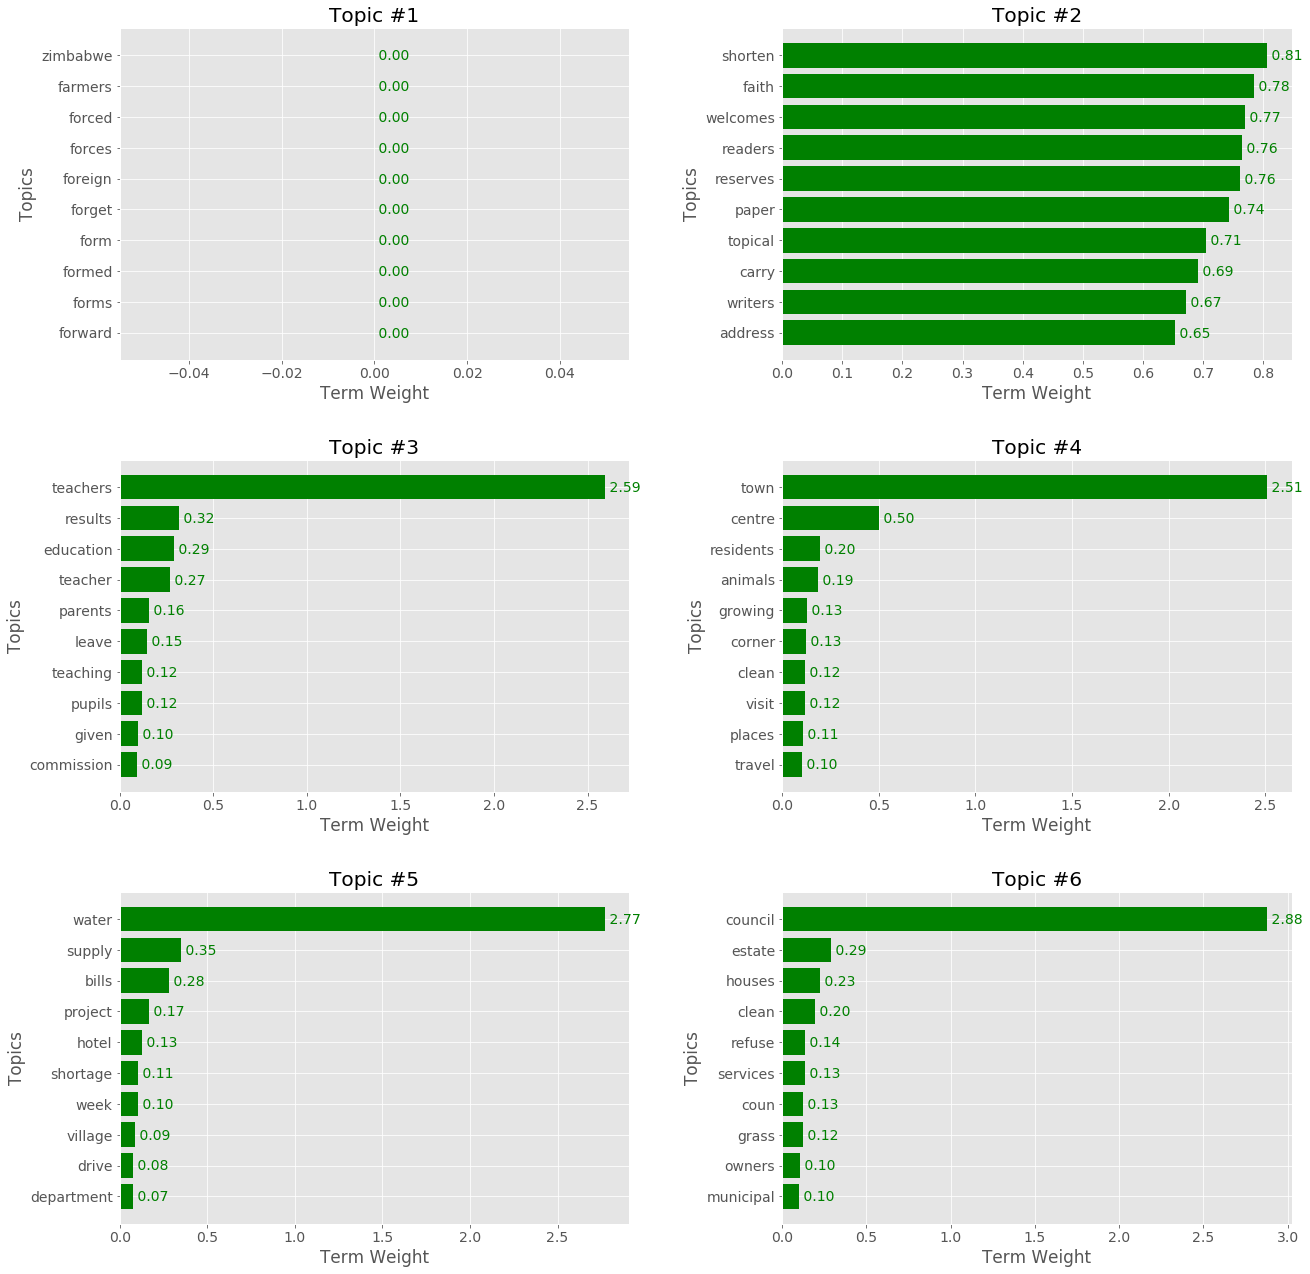

In [20]:
data = np.random.rand(3,101)
data[:,0] = np.arange(2,7,2)
df = pd.DataFrame(data)

fig, axes = plt.subplots(
    nrows=3, 
    ncols=2, 
    figsize=(21,22), 
    sharex=False, 
    sharey=False, 
    gridspec_kw={'hspace': 0.3, 'wspace': 0.3},
)
for i, ax in enumerate(axes.flatten()):
    topic_index = i # topic group index just uses nrows x ncols results
    top = 10 # number of terms to plot
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax.set_title(f'Topic #{i+1}')
    ax.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    ax.set(xlabel='Term Weight', ylabel='Topics')
    for j, v in enumerate(top_weights):
        ax.text(v, j-.15, f" {v:.2f}", color='green')

plt.show()

### Most Relevant Documents
We can also look at the snippets for the top-ranked documents for each topic. We'll define a function to produce this ranking also.

In [21]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

For instance, for the fifth topic listed above–concerning "water shortages"–below are the top 10 documents.

In [22]:
topic_snippets = get_top_snippets( snippets, W, 4, 10 )
for i, snippet in enumerate(topic_snippets):
    print(f"{(i+1):02}. {snippet}")

01. dds-90553-page-8-article-01.txt
02. dds-90478-page-8-article-25.txt
03. dds-90571-page-8-article-22.txt
04. dds-90379-page-8-article-31.txt
05. dds-90479-page-8-article-22.txt
06. dds-90398-page-8-article-11.txt
07. dds-90398-page-8-article-08.txt
08. dds-90546-page-8-article-08.txt
09. dds-90585-page-8-article-04.txt
10. dds-90564-page-8-article-11.txt


## Parameter Selection for NMF

Selecting a useful value for the number of topics to use as determined by NMF. First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using Joblib:

In [23]:
from sklearn.externals import joblib
(tfidf_matrix,terms,snippets) = joblib.load( "letters-tfidf.pkl" )
print( f"Loaded {tfidf_matrix.shape[0]} X {tfidf_matrix.shape[1]} document-term matrix" )

Loaded 3189 X 1164 document-term matrix


### Create the Topic Models
A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of terms.

We need to start by pre-specifying an initial range of "sensible" values:

In [24]:
min_topics, max_topics = 3, 50

In [25]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(min_topics,max_topics+1):
    print("Applying NMF when %d topics ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( tfidf_matrix )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF when 3 topics ...
Applying NMF when 4 topics ...
Applying NMF when 5 topics ...
Applying NMF when 6 topics ...
Applying NMF when 7 topics ...
Applying NMF when 8 topics ...
Applying NMF when 9 topics ...
Applying NMF when 10 topics ...
Applying NMF when 11 topics ...
Applying NMF when 12 topics ...
Applying NMF when 13 topics ...
Applying NMF when 14 topics ...
Applying NMF when 15 topics ...
Applying NMF when 16 topics ...
Applying NMF when 17 topics ...
Applying NMF when 18 topics ...
Applying NMF when 19 topics ...
Applying NMF when 20 topics ...
Applying NMF when 21 topics ...
Applying NMF when 22 topics ...
Applying NMF when 23 topics ...
Applying NMF when 24 topics ...
Applying NMF when 25 topics ...
Applying NMF when 26 topics ...
Applying NMF when 27 topics ...
Applying NMF when 28 topics ...
Applying NMF when 29 topics ...
Applying NMF when 30 topics ...
Applying NMF when 31 topics ...
Applying NMF when 32 topics ...
Applying NMF when 33 topics ...
Applying NMF wh

In [26]:
import re

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )
        #self.tokenizer = re.compile( r"(?u)\b(\w|\s)+\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 4:
                    tokens.append( tok )
            yield tokens

In [27]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
# min_count=20 ignore all words with a total frequency of less than min_count i.e. 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, iter=20, sg=1)

Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...
Building Word2Vec model...


In [28]:
print( f"Model has {len(w2v_model.wv.vocab)} terms" )

Model has 1403 terms


In [29]:
w2v_model.save("w2v-model.bin")

In [30]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### Selecting the Number of Topics
Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [31]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        try:
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        except Exception as e:
            print(e)
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

Now process each of the models for different values of topic terms using the topic descriptor function we defined earlier (i.e. list of top terms).

In [32]:
from itertools import combinations
topics_values = []
coherences = []
print(f"K\tCoherence")
for (topics, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(topics):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    topics_values.append( topics )

    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print(f"{topics:02}\t{coherences[-1]:.4f}")        

K	Coherence
03	0.4131
04	0.3957
05	0.3977
06	0.4040
07	0.3965
08	0.4070
09	0.4168
10	0.4154
11	0.4117
12	0.4187
13	0.4083
14	0.4143
15	0.4226
16	0.3996
17	0.4069
18	0.4205
19	0.4146
20	0.4022
21	0.3971
22	0.4031
23	0.3957
24	0.4014
25	0.3999
26	0.4048
27	0.4038
28	0.3861
29	0.3913
30	0.3977
"word 'dear' not in vocabulary"
31	0.3822
32	0.3775
33	0.3840
34	0.3881
35	0.3885
36	0.3877
"word 'dear' not in vocabulary"
37	0.3888
38	0.3858
"word 'dear' not in vocabulary"
39	0.3973
"word 'dear' not in vocabulary"
40	0.3892
"word 'dear' not in vocabulary"
41	0.3926
"word 'dear' not in vocabulary"
42	0.3806
"word 'dear' not in vocabulary"
43	0.3948
"word 'dear' not in vocabulary"
44	0.3956
"word 'dear' not in vocabulary"
45	0.3930
"word 'dear' not in vocabulary"
46	0.3860
"word 'dear' not in vocabulary"
47	0.3814
"word 'dear' not in vocabulary"
48	0.3844
"word 'dear' not in vocabulary"
49	0.3805
"word 'dear' not in vocabulary"
50	0.3808


We can now use matplotlib to generate a line plot of these coherence scores, to help us select an appropriate value.

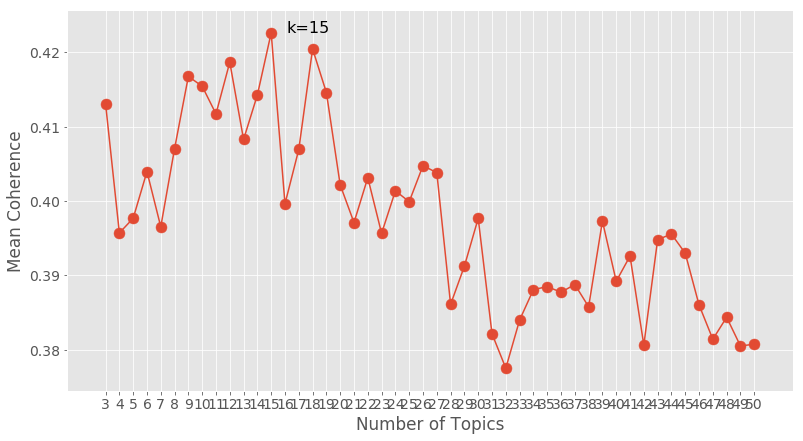

In [33]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( topics_values, coherences )
plt.xticks(topics_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( topics_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_topics = topics_values[xpos]
plt.annotate( f"k={best_topics}", xy=(best_topics, ymax), xytext=(best_topics, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

### Examine the Final Model
The plot above suggests only upto the first 9 topics are we able to get the most coherent models. This means that documents associated with these topics are appropriately themed by the topic terms representing that topic.

In [34]:
k = best_topics
# get the model that we generated earlier.
W = topic_models[k-min_topics][1]
H = topic_models[k-min_topics][2]

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print(f"Topic {topic_index+1:02}: {str_descriptor}")

Topic 01: south, leaders, news, national, issue, society, development, economic, countries, work
Topic 02: editor, shorten, readers, paper, welcomes, faith, reserves, topical, address, carry
Topic 03: school, teachers, schools, students, education, parents, secondary, results, primary, girls
Topic 04: town, area, district, roads, centre, health, residents, farmers, location, animals
Topic 05: water, supply, bills, project, hotel, shortage, week, action, drive, development
Topic 06: council, estate, houses, clean, airways, refuse, roads, services, grass, coun
Topic 07: children, times, child, home, work, mothers, care, shops, quickly, play
Topic 08: president, kenyans, kenyatta, peace, unity, jomo, father, beloved, live, love
Topic 09: high, mara, looking, game, look, sign, book, masai, uhuru, board
Topic 10: thank, help, thanks, hospital, helped, friend, assistance, harambee, kind, raise
Topic 11: street, lights, house, light, dark, traffic, power, england, commission, touch
Topic 12: 

#### Generating data to train the UNESCO thesaurus

Three function were created to generate training datasets that follow the document format used by Annif. 

*  **`identify_topic_subjects`**  
This function used the top topic descriptors listed above and additionally performed permutations of these descriptors to generated descriptors-pairs. The unigrams and quasi-bigrams were matched with terms in the UNESCO vocabulary. The omittance of normalization (stemming or lemmatization) ensured that the top descriptors also co-occured and there provided another vector for mapping with the controlled vocabulary. Phrases such as "civil servants", "post office" as bigrams could thus be costructed from the descriptors. This function returned a list of matched terms from the controlled vocabulary that would be filtered shortly for individual documents the cover the topic.


*  **`term_matched_with_file`**  
Topic descriptors were also against the documents associated with each topic. Text in each document that matched descriptors were _filtered_ in order to provide better specificity since the expanded descriptors list meant that some terms could be misattributed if done wholesale.


*  **`filtered_terms`**  
Terms matched in the individual document were search with the earlier created identified vocabulary terms to create a final list of terms that will describe this document for purposes of training.

In [36]:
def identify_topic_subjects(descriptors, unesco_terms):
    # include permutations of the terms as 'artificial bigrams'
    descriptor_perms = list(itertools.permutations(descriptors, 2))  # list of tuples
    descriptor_pairs = [f"{pair[0]} {pair[1]}" for pair in descriptor_perms]
    descriptors.extend(descriptor_pairs)
    
    term_no_dicts = []
    # loop through the terms 'descriptor' and search for exact matches in the unesco thesaurus
    for descriptor in descriptors:
        # search and log the lines they matched with
        results = [re.search(rf'^{descriptor}+([a-z]$|$)', term) for term in unesco_terms]
        indexes = [(unesco_terms[i], i) for i,v in enumerate(results) if v]
        term_no_dicts.extend(indexes)
        
    # convert to dictionary for easy handling
    return dict(term_no_dicts)

def term_matched_with_file(file_path, descriptors):
    with open(f'{file_path}', 'r', encoding='utf-8') as train_file:
        full_text = train_file.read()
        text_tokens = nltk.word_tokenize(full_text) # Split the sentence into words

        terms_matched = []  # in this file alone
        # use the match + exact file matches list to extract these lines as the .key file for training
        for descriptor in descriptors:
            matched = [re.search(rf'^{descriptor}+([a-z]|$)', text_t) for text_t in text_tokens]
            matched_cleanup = [i for i,v in enumerate(matched) if v] 
            if len(matched_cleanup) > 0:
                terms_matched.append(descriptor)

        return terms_matched
    
def filtered_terms(term_no_dicts, terms_matched):
    rows_to_write = []
    for tm in terms_matched:
        res = [val for key, val in term_no_dicts.items() if key.startswith(tm)]
        rows_to_write.extend(res)

    return list(dict.fromkeys(rows_to_write)) # remove dups

Use this to create training model associated with the UNESCO thesaurus and test it on the 1975, and validate on 1976 ...

In [37]:
# read the unesco tsv file
# load all the terms in a list
import csv
from shutil import copyfile
import glob
import itertools

final_directory = f'{annif_unesco_dir}/{proc_year}'
if not os.path.exists(final_directory):
    os.makedirs(final_directory)
# empty unesco training dir every time you run this
# since the vocab files are appendable an could end up 
# with duplicated terms
files = glob.glob(f'{final_directory}/*')
for f in files:
    os.remove(f)

unesco_rows = []
unesco_terms = []
with open(f"{vocabs_dir}/unesco-en.tsv") as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    for line_no, line in enumerate(tsvreader):
        uri = line[0]
        term = line[1]
        unesco_terms.append(term.lower())
        unesco_rows.append([uri, term])

for topic_index in range(k):
    descriptors = get_descriptor( terms, H, topic_index, 20 ) # top 20 terms in a topic
    str_descriptor = ", ".join( descriptors )
    print(f"Topic {topic_index+1:02}: {str_descriptor}")
    
    term_no_dicts = identify_topic_subjects(descriptors, unesco_terms)

    topic_snippets = get_top_snippets( snippets, W, topic_index, 20 ) # top 20 documents on this topic
    for i, snippet in enumerate(topic_snippets):
        fname_sans_ext = os.path.splitext(snippet)[0]
        file_path = f'{txt_proc_dir}/{proc_year}/{snippet}'
        
        terms_matched = term_matched_with_file(file_path, descriptors)

        rows_to_write = filtered_terms(term_no_dicts, terms_matched)
                
        if len(rows_to_write) > 0: # miss empty lists
            print(", ".join([key for key, val in term_no_dicts.items()]))
            # write key file with found associated unesco terms
            # opening the .key file shoul be a+ to append similar matches
            with open(f'{final_directory}/{fname_sans_ext}.key', 'a+') as keyfile:
                              
                writer = csv.writer(keyfile, delimiter='\t', lineterminator='\n')
                for row in rows_to_write:
                    t_row = unesco_rows[row]
                    writer.writerow([t_row[0], t_row[1]])
                
                copyfile(f"{txt_proc_dir}/{proc_year}/{snippet}", f"{final_directory}/{snippet}")
        
        print(f"\t{snippet}")

Topic 01: south, leaders, news, national, issue, society, development, economic, countries, work, political, life, true, editorial, africans, union, sure, social, power, best
economics, political power, social work
	dds-90503-page-8-article-06.txt
economics, political power, social work
	dds-90345-page-8-article-01.txt
economics, political power, social work
	dds-90375-page-8-article-06.txt
economics, political power, social work
	dds-90375-page-8-article-08.txt
economics, political power, social work
	dds-90375-page-8-article-07.txt
	dds-90547-page-8-article-01.txt
economics, political power, social work
	dds-90335-page-8-article-00.txt
economics, political power, social work
	dds-90341-page-8-article-09.txt
	dds-90532-page-8-article-06.txt
economics, political power, social work
	dds-90335-page-8-article-02.txt
economics, political power, social work
	dds-90385-page-8-article-21.txt
economics, political power, social work
	dds-90378-page-8-article-14.txt
economics, political power, s

roads, health, farmers, animals, hospitals
	dds-90368-page-8-article-16.txt
roads, health, farmers, animals, hospitals
	dds-90372-page-8-article-13.txt
	dds-90432-page-8-article-17.txt
roads, health, farmers, animals, hospitals
	dds-90548-page-8-article-12.txt
	dds-90377-page-8-article-20.txt
	dds-90450-page-8-article-22.txt
	dds-90471-page-8-article-04.txt
roads, health, farmers, animals, hospitals
	dds-90455-page-8-article-13.txt
roads, health, farmers, animals, hospitals
	dds-90555-page-8-article-09.txt
	dds-90381-page-8-article-24.txt
roads, health, farmers, animals, hospitals
	dds-90372-page-8-article-12.txt
	dds-90366-page-8-article-15.txt
	dds-90532-page-8-article-08.txt
	dds-90570-page-8-article-26.txt
	dds-90447-page-8-article-03.txt
roads, health, farmers, animals, hospitals
	dds-90441-page-8-article-17.txt
roads, health, farmers, animals, hospitals
	dds-90522-page-8-article-05.txt
	dds-90569-page-8-article-06.txt
	dds-90543-page-8-article-16.txt
	dds-90581-page-8-article-27.

	dds-90476-page-8-article-04.txt
	dds-90609-page-8-article-15.txt
	dds-90466-page-8-article-08.txt
	dds-90549-page-8-article-03.txt
	dds-90417-page-8-article-04.txt
	dds-90444-page-8-article-14.txt
	dds-90495-page-8-article-09.txt
hospitals, schools, school visits
	dds-90558-page-8-article-13.txt
hospitals, schools, school visits
	dds-90463-page-8-article-28.txt
	dds-90401-page-8-article-17.txt
	dds-90335-page-8-article-07.txt
	dds-90390-page-8-article-27.txt
hospitals, schools, school visits
	dds-90407-page-8-article-19.txt
hospitals, schools, school visits
	dds-90526-page-8-article-24.txt
	dds-90384-page-8-article-06.txt
	dds-90576-page-8-article-21.txt
	dds-90410-page-8-article-17.txt
	dds-90516-page-8-article-14.txt
	dds-90411-page-8-article-02.txt
hospitals, schools, school visits
	dds-90558-page-8-article-14.txt
Topic 11: street, lights, house, light, dark, traffic, power, england, commission, touch, safe, gives, effective, streets, london, opportunity, special, roads, parking, a

somalia, israel, ethiopia, arabs, somali, egypt, peace, nations, state, arab states
	dds-90352-page-8-article-14.txt
Topic 15: police, drivers, traffic, rally, matata, status, safari, station, vehicles, cars, waiting, left, night, motorists, vehicle, driver, driving, went, officers, hours
police, traffic, vehicles
	dds-90402-page-8-article-22.txt
police, traffic, vehicles
	dds-90425-page-8-article-09.txt
police, traffic, vehicles
	dds-90339-page-8-article-20.txt
police, traffic, vehicles
	dds-90348-page-8-article-18.txt
police, traffic, vehicles
	dds-90592-page-8-article-01.txt
police, traffic, vehicles
	dds-90476-page-8-article-21.txt
police, traffic, vehicles
	dds-90476-page-8-article-22.txt
police, traffic, vehicles
	dds-90427-page-8-article-12.txt
police, traffic, vehicles
	dds-90338-page-8-article-13.txt
police, traffic, vehicles
	dds-90610-page-8-article-16.txt
police, traffic, vehicles
	dds-90586-page-8-article-20.txt
police, traffic, vehicles
	dds-90593-page-8-article-21.txt
po

### Resources


1.  Formatting of numpy arrays. [See](https://stackoverflow.com/questions/2891790/how-to-pretty-print-a-numpy-array-without-scientific-notation-and-with-given-pre/2891805)  
*  Intepretation of [TM](https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d)

In [38]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from nltk.corpus import wordnet

sentences = "Topic 01: zimbabwe, general, form, formed, forms, forward, free, freedom, fresh, friend, Topic 02: welcomes, readers, topical, shorten, faith, reserves, carry, brief, address, paper, Topic 03: children, times, child, home, mothers, care, shops, parents, play, middle, Topic 04: area, residents, authorities, note, location, thugs, parking, progress, especially, farmers, Topic 05: water, supply, project, hotel, week, shortage, village, drive, department, river, Topic 06: council, estate, houses, clean, health, refuse, services, hazard, coun, municipal, Topic 07: somalia, barre, ethiopia, ogaden, somali, countries, arms, siad, horn, greater, Topic 08: teachers, results, education, teacher, college, parents, leave, teaching, pupils, given, Topic 09: thanks, helped, note, night, helping, wish, highway, friend, newspaper, staff, Topic 10: street, lights, dark, light, traffic, gives, effective, safe, streets, commission, Topic 11: post, office, telephone, counter, services, long, number, takes, difficult, comment, Topic 12: school, students, girls, secondary, primary, parents, fees, lunch, boys, study, Topic 13: police, station, traffic, officers, force, night, waiting, duty, went, crime, Topic 14: mara, looking, high, game, look, masai, book, russian, night, friends, Topic 15: help, sick, address, progress, cannon, businessmen, duty, enable, send, child, Topic 16: rally, drivers, safari, africans, event, cars, look, believe, race, kenyan, Topic 17: thank, saying, helped, behalf, vital, excellent, assistance, raise, grateful, took, Topic 18: news, taken, item, order, readers, october, reported, chance, shortage, west, Topic 19: price, prices, control, sugar, commodities, budget, increase, cent, meat, salt, Topic 20: town, centre, residents, animals, corner, growing, visit, clean, places, appeal, Topic 21: israel, peace, sadat, arab, state, egypt, middle, arabs, david, editorial, Topic 22: money, paid, location, business, legal, wananchi, projects, working, waiting, project, Topic 23: service, civil, servants, train, limited, private, send, duty, medical, better, Topic 24: house, rents, rent, houses, housing, landlords, transport, touch, famous, trust, Topic 25: land, food, plots, chance, ther, owners, kisumu, occupied, value, thes, Topic 26: work, hard, order, telephone, number, issue, thing, ring, enable, short, Topic 27: sure, standard, hard, duty, health, send, somali, black, enter, issue, Topic 28: zimbabwe, general, form, formed, forms, forward, free, freedom, fresh, friend, Topic 29: president, kenyatta, peace, jomo, unity, beloved, father, silent, leader, arap, Topic 30: power, electricity, company, half, supply, happy, reader, lights, zimbabwe, times, Topic 31: schools, education, ministry, teaching, pupils, secondary, primary, exam, form, subjects, Topic 32: action, needed, telephone, choice, hall, taken, calls, april, wish, build, Topic 33: district, location, busia, farmers, province, assistant, development, basis, officers, tribal, Topic 34: tion, swahili, king, lesson, high, funds, ment, shortage, cost, situation, Topic 35: harambee, projects, spirit, contribute, forced, editorial, meets, project, march, province, Topic 36: roads, potholes, commission, state, repair, ministry, attention, main, rains, condition, Topic 37: live, ther, long, freedom, forces, deep, safety, august, huge, evening, Topic 38: park, game, lions, wildlife, animals, december, night, left, tourism, ministry, Topic 39: airways, farmers, businessmen, company, servants, usual, march, province, shall, meeting, Topic 40: thought, food, opened, seeking, girls, season, john, deep, life, truth, Topic 41: editor, cause, intended, editorial, huge, welcomes, issue, shorten, great, victims, Topic 42: matata, status, traffic, vehicles, passengers, drivers, driver, vehicle, accidents, motorists, Topic 43: june, round, took, read, unable, build, july, bear, sunday, long, Topic 44: poor, rich, chance, hotels, health, uhuru, hard, doctors, today, especially, Topic 45: south, apartheid, africans, violence, black, blacks, white, regime, countries, chief, Topic 46: cards, issue, charge, given, bungoma, doing, told, travelling, report, sell, Topic 47: beer, drinking, shortage, list, areas, dangerous, goods, waiting, taken, despite, Topic 48: kenyans, kenyan, ought, meets, love, uganda, wildlife, kenyatta, foreign, organisations, Topic 49: hospital, patients, treatment, health, doctors, medical, wananchi, kind, private, opened, Topic 50: leaders, national, development, society, problem, life, economic, true, cannon, countries"

result = [x.strip() for x in sentences.split(',')]

for sent in result:
    print(wnl.lemmatize(sent, pos=wordnet.NOUN), '======', sent)

Topic 01: zimbabwe ====== Topic 01: zimbabwe
general ====== general
form ====== form
formed ====== formed
form ====== forms
forward ====== forward
free ====== free
freedom ====== freedom
fresh ====== fresh
friend ====== friend
Topic 02: welcomes ====== Topic 02: welcomes
reader ====== readers
topical ====== topical
shorten ====== shorten
faith ====== faith
reserve ====== reserves
carry ====== carry
brief ====== brief
address ====== address
paper ====== paper
Topic 03: children ====== Topic 03: children
time ====== times
child ====== child
home ====== home
mother ====== mothers
care ====== care
shop ====== shops
parent ====== parents
play ====== play
middle ====== middle
Topic 04: area ====== Topic 04: area
resident ====== residents
authority ====== authorities
note ====== note
location ====== location
thug ====== thugs
parking ====== parking
progress ====== progress
especially ====== especially
farmer ====== farmers
Topic 05: water ====== Topic 05: water
supply ====== supply
project ==

In [39]:
import itertools
texts = "union, worker, civil, servant, salary, service, wage, observer, employer, secretary"
words = texts.split(', ')
print(words)

pairs = list(itertools.permutations(words, 2))
print(len(pairs))
perms = [f"{pair[0]} {pair[1]}" for pair in pairs]
print(perms)

['union', 'worker', 'civil', 'servant', 'salary', 'service', 'wage', 'observer', 'employer', 'secretary']
90
['union worker', 'union civil', 'union servant', 'union salary', 'union service', 'union wage', 'union observer', 'union employer', 'union secretary', 'worker union', 'worker civil', 'worker servant', 'worker salary', 'worker service', 'worker wage', 'worker observer', 'worker employer', 'worker secretary', 'civil union', 'civil worker', 'civil servant', 'civil salary', 'civil service', 'civil wage', 'civil observer', 'civil employer', 'civil secretary', 'servant union', 'servant worker', 'servant civil', 'servant salary', 'servant service', 'servant wage', 'servant observer', 'servant employer', 'servant secretary', 'salary union', 'salary worker', 'salary civil', 'salary servant', 'salary service', 'salary wage', 'salary observer', 'salary employer', 'salary secretary', 'service union', 'service worker', 'service civil', 'service servant', 'service salary', 'service wage', 'se

In [40]:
import sklearn
print(sklearn.__version__, gensim.__version__, nltk.__version__)

0.19.1 3.3.0 3.2.3
